In [106]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
import torch.autograd.variable as Variable
from torch import optim
import math, random
from matplotlib import pyplot as plt

## Будем работать с данными акселерометра, поэтому нашей моделью является RNN

In [89]:
#загружаем данные
Data = pd.read_csv('WISDM_ar_v1.1_raw.txt', names= ["user-id", "activity", "timestamp", "x-axis", "y-axis", "z-axis"])
Data["z-axis"] = [float(str(Element).replace(";", "")) for Element in Data["z-axis"]]
Data.dropna(axis=0,inplace=True)
#Data = Data.iloc[np.random.permutation(len(Data))]
Data.rename(columns={'user-id':'user'},inplace=True)

cl=["user", "timestamp", "x-axis", "y-axis", "z-axis"]
#Data[cl].astype('float',inplace=True)
#print(Data.head())
#print(Data.describe())
Data = np.array(Data[:int(0.8*len(Data))])
Data_test = np.array(Data[int(0.8*len(Data)):])

In [90]:
for i in range(2,6):
    Data[:,i]=Data[:,i].astype('float')

In [91]:
users = set()
activities = ["Downstairs", "Jogging", "Upstairs", "Walking"]
for index in range(len(Data)):
    users.add(Data[index][0])
users = list(users)

In [92]:
Data_Sort = []
y_sort = []
activities = ["Downstairs", "Jogging", "Upstairs", "Walking"]
index = 0
while index < len(Data):
    Data_current = []
    pers = Data[index][0]
    act = Data[index][1]
    y_sort.append(Data[index][1])
    while Data[index][0] == pers and Data[index][1] == act :
        Data_current.append(Data[index][2:])
        index += 1
        if index == len(Data):
            break
    Data_Sort.append(Data_current)

In [93]:
#Data_Sort = np.array(Data_Sort)
y_sort = np.array(y_sort)


In [94]:
y_sort = np.array(pd.get_dummies(y_sort))
type(Data_Sort[1])

list

## Создадим класс, который насследует nn.Module. Переопределим функции

In [95]:

class SimpleRNN(nn.Module):
    def __init__(self, hidden_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size

        self.inp = nn.Linear(4, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, 2, dropout=0.05)
        self.out = nn.Linear(hidden_size, 6)
        self.our=nn.Softmax()
    def step(self, input, hidden=None):
        #print(f"input_size={input.size}")
        input = self.inp(input.view(1, -1)).unsqueeze(1)
        #print(f"input2_size={input.size}")
        output, hidden = self.rnn(input, hidden)

        output = self.out(output.squeeze(1))
        output=self.our(output.squeeze(1))
        return output, hidden

    def forward(self, inputs, hidden=None, force=True, steps=0):
        if force or steps == 0: steps = len(inputs)
        outputs = Variable(torch.zeros(steps, 1, 6))
        for i in range(steps):
            #if force or i == 0:
            input = inputs[i]
            #else:
                #input = output
            #pdb.set_trace()
            output, hidden = self.step(input, hidden)
            outputs[i] = output
        return outputs, hidden

## Попробуем обучить нашу модель, поралельно будем следить за ошибкой

In [96]:

def accuracy(prediction, answer):
    i = 0.
    for x, y in zip(prediction, answer):
        if(int(x) == int(y)):
            i += 1
    return i / (len(answer))
ts1=torch.tensor([[1,2,6],[3,4,5]],dtype=torch.float32)
ts2=torch.tensor([[7,26,66],[34,44,54]],dtype=torch.float32)
#accuracy(ts1,ts2)
ts1_s=ts1[:][0]
for i in range(1,2):
    ts1_s+=ts1[:][i]
        
ts1_s

tensor([ 4.,  6., 11.])

In [97]:

n_epochs = 1
n_iters = 100
hidden_size = 5

model = SimpleRNN(hidden_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

losses = np.zeros(n_iters)  # For plotting

for epoch in range(n_epochs):
    
    for n in range(n_iters):
        X_train1=Data_Sort[n]
        Y_train1=np.array([y_sort[n] for i in range(0,len(X_train1))])
        
        #ix = np.random.randint(0, len(X_train1), 20)
        x_batch = torch.tensor(X_train1, dtype=torch.float32)
        y_batch = torch.tensor(Y_train1, dtype=torch.float32)

        #force = random.random() < 0.5
        #gdb.set_trace()
        #pdb.set_trace()
        lst=list()
        lst_pred=list()
        for i in range(0,20):
            q1=int(i*len(X_train1)/20)
            q2=int((i+1)*len(X_train1)/20)
            x_batch_=x_batch[q1:q2]
            y_batch_=y_batch[q1:q2]
            outputs, hidden = model(x_batch_, None)

            optimizer.zero_grad()
            y_batch_=y_batch_.view(q2-q1,1,6)
            lst.append(np.argmax(y_sort[n]))
            lst_pred.append(torch.argmax(outputs[-1]))
            #print(f"lst={lst}")
            #y_batch_np=y_batch.view(len(X_train1),6)
            #out_np=outputs.view(len(X_train1),6)
            #y1=[torch.argmax(y_batch_np[i])for i in range(0,len(X_train1))]
            #y1_pred=[torch.argmax(out_np[i])for i in range(0,len(X_train1))]
            loss = criterion(outputs, y_batch_)
            loss.backward()
            optimizer.step()
            #print(y1)
        acc=accuracy(lst,lst_pred)
        print(f"accuracy={acc}")
        

        losses[n] += loss.data[0]

        if n > 0:
            print(n, loss.data[0])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/autograd/__init__.py:167: UserWarning: torch.autograd.variable(...) is deprecated, use torch.tensor(...) instead
  warnings.warn("torch.autograd.variable(...) is deprecated, use torch.tensor(...) instead")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


accuracy=0.0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


accuracy=1.0
1 tensor(0.1234)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


accuracy=0.0
2 tensor(0.1247)
accuracy=0.0
3 tensor(0.1394)
accuracy=0.35
4 tensor(0.1244)
accuracy=0.0
5 tensor(0.1389)
accuracy=0.95
6 tensor(0.1236)
accuracy=0.0
7 tensor(0.1384)
accuracy=1.0
8 tensor(0.1231)
accuracy=0.0
9 tensor(0.1379)
accuracy=0.0
10 tensor(0.1569)
accuracy=0.0
11 tensor(0.1251)
accuracy=0.0
12 tensor(0.1568)
accuracy=0.0
13 tensor(0.1242)
accuracy=0.0
14 tensor(0.1565)
accuracy=0.6
15 tensor(0.1234)
accuracy=0.0
16 tensor(0.1562)
accuracy=1.0
17 tensor(0.1226)
accuracy=0.0
18 tensor(0.1559)
accuracy=0.0
19 tensor(0.1243)
accuracy=0.0
20 tensor(0.1387)
accuracy=0.4
21 tensor(0.1236)
accuracy=0.0
22 tensor(0.1382)
accuracy=0.95
23 tensor(0.1228)
accuracy=0.0
24 tensor(0.1377)
accuracy=1.0
25 tensor(0.1221)
accuracy=0.0
26 tensor(0.1371)
accuracy=0.0
27 tensor(0.1364)
accuracy=0.0
28 tensor(0.1248)
accuracy=0.15
29 tensor(0.1238)
accuracy=0.0
30 tensor(0.1565)
accuracy=0.65
31 tensor(0.1230)
accuracy=0.0
32 tensor(0.1561)
accuracy=0.3
33 tensor(0.1234)
accuracy=0.

## Перейдем на тестовую выборку

In [98]:
for i in range(2,6):
    Data_test[:,i]=Data_test[:,i].astype('float')

In [99]:
users_test = set()
activities_test = ["Downstairs", "Jogging", "Upstairs", "Walking"]
for index in range(len(Data_test)):
    users_test.add(Data_test[index][0])
users_test = list(users_test)

In [100]:
Data_Sort_test = []
y_sort_test = []
activities = ["Downstairs", "Jogging", "Upstairs", "Walking"]
index = 0
while index < len(Data_test):
    Data_current_test = []
    pers_test = Data_test[index][0]
    act_test = Data_test[index][1]
    y_sort_test.append(Data_test[index][1])
    while Data_test[index][0] == pers_test and Data_test[index][1] == act_test :
        Data_current_test.append(Data_test[index][2:])
        index += 1
        if index == len(Data_test):
            break
    Data_Sort_test.append(Data_current_test)

In [101]:
#Data_Sort = np.array(Data_Sort)
y_sort_test = np.array(y_sort_test)
y_sort_test = np.array(pd.get_dummies(y_sort_test))
type(Data_Sort_test[1])

list

In [102]:
#Data_Sort_test[1]
#len(Data_Sort_test)

In [103]:
accc=list()
for n in range(60):
        X_train1_test=Data_Sort_test[n]
        Y_train1_test=np.array([y_sort_test[n] for i in range(0,len(X_train1_test))])
        
        #ix = np.random.randint(0, len(X_train1), 20)
        x_batch_test = torch.tensor(X_train1_test, dtype=torch.float32)
        y_batch_test = torch.tensor(Y_train1_test, dtype=torch.float32)

        #force = random.random() < 0.5
        #gdb.set_trace()
        #pdb.set_trace()
        lst_test=list()
        lst_pred_test=list()
        for i in range(0,5):
            q1_test=int(i*len(X_train1_test)/20)
            q2_test=int((i+1)*len(X_train1_test)/20)
            x_batch__test=x_batch_test[q1_test:q2_test]
            y_batch__test=y_batch_test[q1_test:q2_test]
            outputs_test, hidden_test = model(x_batch__test, None)
            y_batch__test=y_batch__test.view(q2_test-q1_test,1,6)
            lst_test.append(np.argmax(y_sort_test[n]))
            lst_pred_test.append(torch.argmax(outputs_test[-1]))
            #print(f"lst={lst}")
            #y_batch_np=y_batch.view(len(X_train1),6)
            #out_np=outputs.view(len(X_train1),6)
            #y1=[torch.argmax(y_batch_np[i])for i in range(0,len(X_train1))]
            #y1_pred=[torch.argmax(out_np[i])for i in range(0,len(X_train1))]
            
            #print(y1)
        acc_test=accuracy(lst_test,lst_pred_test)
        accc.append(acc_test)
        print(f"accuracy={acc}")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/autograd/__init__.py:167: UserWarning: torch.autograd.variable(...) is deprecated, use torch.tensor(...) instead
  warnings.warn("torch.autograd.variable(...) is deprecated, use torch.tensor(...) instead")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0
accuracy=0.0


## Построим график


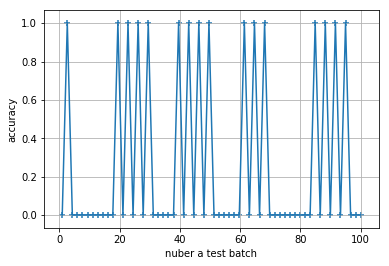

In [107]:
x3=np.linspace(1,100,len(accc))
plt.plot(x3,accc)
plt.scatter(x3,accc,marker='+')
plt.grid(True)
plt.xlabel("nuber a test batch")
plt.ylabel("accuracy")
plt.show()